[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.1919 - mae: 0.4347 - val_loss: 3.1682 - val_mae: 2.8621 - learning_rate: 8.0000e-04
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0368 - mae: 0.2044 - val_loss: 3.0336 - val_mae: 2.7724 - learning_rate: 8.0000e-04
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0336 - mae: 0.1923 - val_loss: 2.5660 - val_mae: 2.4606 - learning_rate: 8.0000e-04
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0277 - mae: 0.1720 - val_loss: 2.4380 - val_mae: 2.3753 - learning_rate: 8.0000e-04
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0202 - mae: 0.1449 - val_loss: 1.8989 - val_mae: 2.0146 - learning_rate: 8.0000e-04
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0191 - mae: 0.1393 - val_loss: 1.6481 - val_mae: 1.8449 - learning_rate: 8.0000e-04
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0140 - mae: 0.1233 - val_loss: 1.3936 - val_mae: 1.6686 - lea

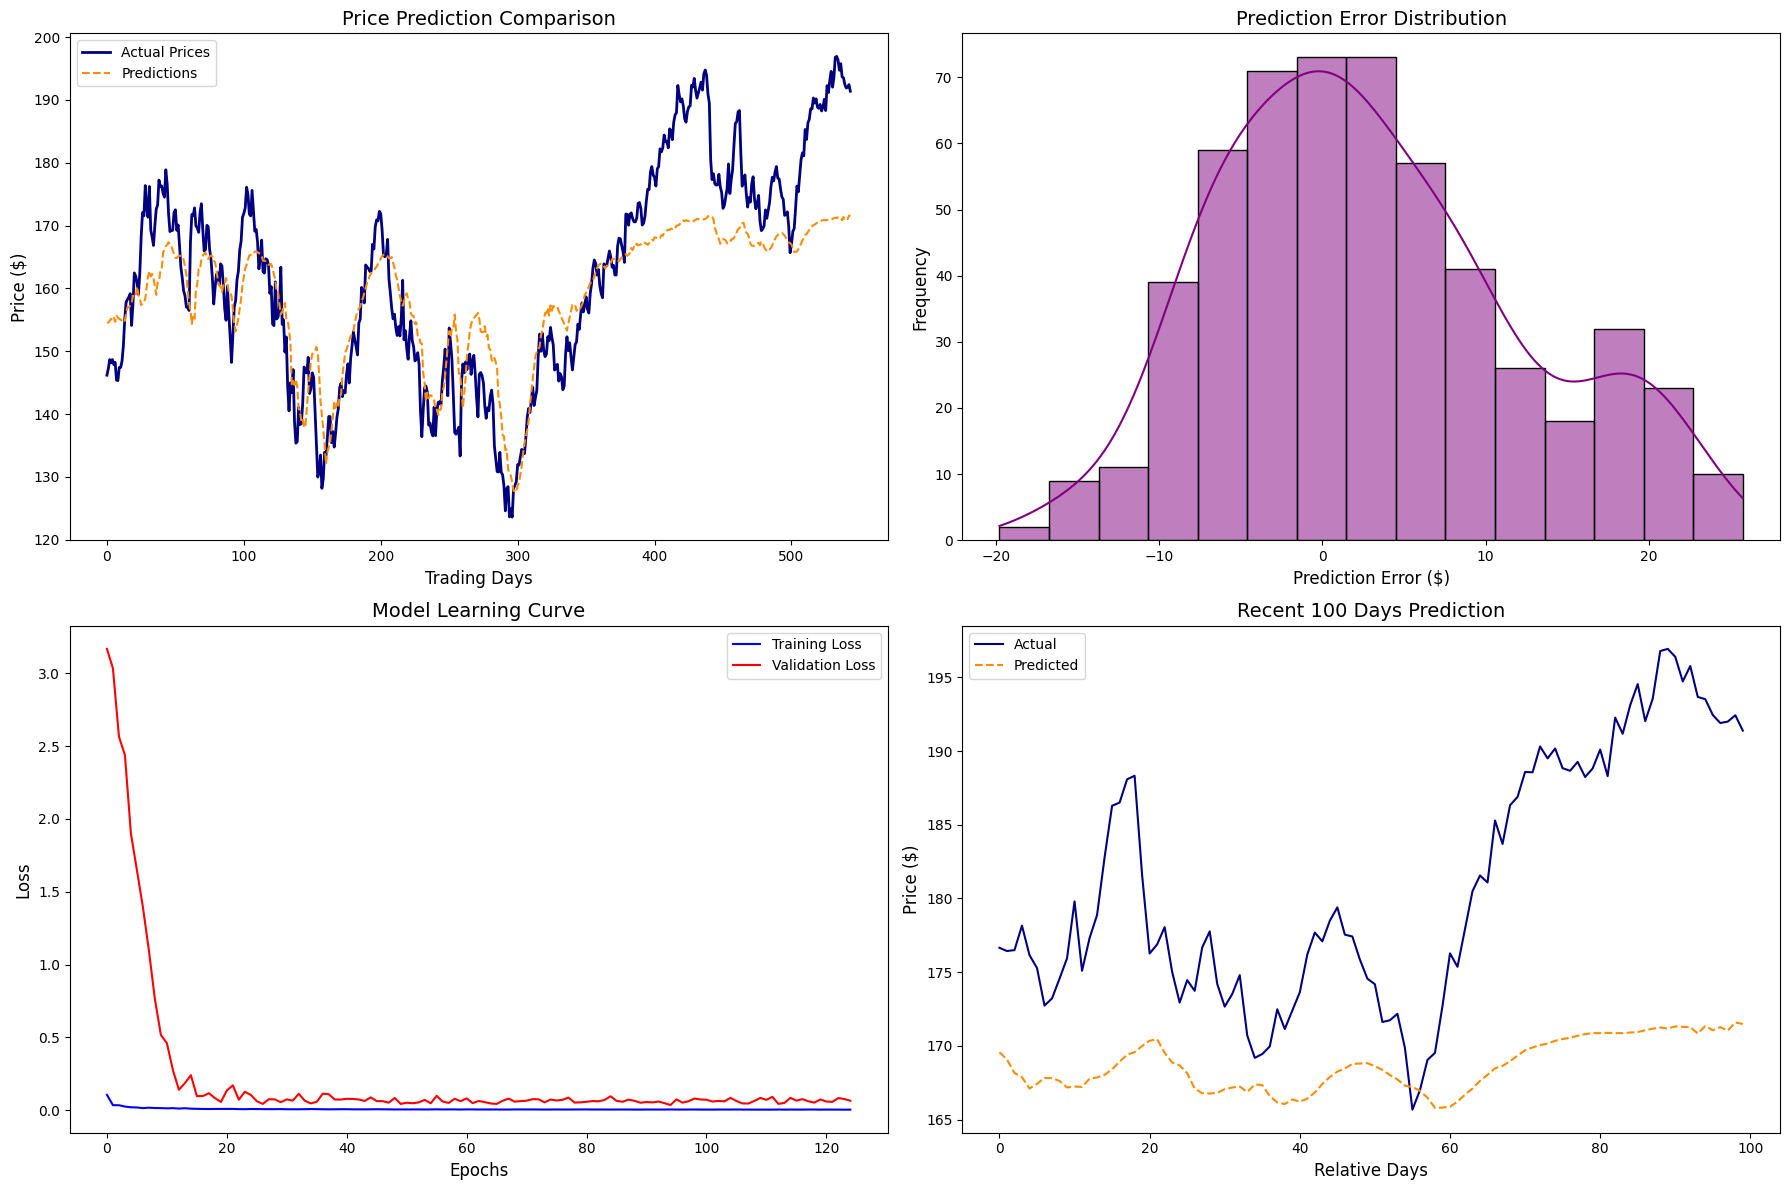

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import Huber

# Download Apple stock data
df = yf.download('AAPL', start='2013-01-01', end='2023-12-31')
df.reset_index(inplace=True)

# Feature Engineering with MA44
n_lags = 7
df['MA44'] = df['Close'].rolling(window=44).mean()

# Create lagged features for multiple time steps
for lag in range(1, n_lags+1):
    df[f'Close_Lag{lag}'] = df['Close'].shift(lag)
    df[f'Volume_Lag{lag}'] = df['Volume'].shift(lag)
    df[f'MA44_Lag{lag}'] = df['MA44'].shift(lag)

# Create target variable (next day's closing price)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

# Feature Selection with MA44
features = []
for lag in range(1, n_lags+1):
    features.extend([f'Close_Lag{lag}', f'Volume_Lag{lag}', f'MA44_Lag{lag}'])

X = df[features]
y = df['Target']

# Time-based Train-Test Split
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Feature Scaling
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Target Scaling
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Reshape data for Conv1D/LSTM (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], n_lags, 3))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], n_lags, 3))

# Optimized Hybrid Model Architecture
model = Sequential()

# Temporal Feature Extraction Block
model.add(Conv1D(128, 2, activation='relu', input_shape=(n_lags, 3)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

# Sequence Processing Block
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh')))
model.add(Bidirectional(LSTM(50, activation='tanh')))
model.add(Dropout(0.3))

# Trend Forecasting Block
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Enhanced Learning Rate Schedule
def lr_scheduler(epoch, lr):
    if epoch < 15:
        return 0.0008
    elif epoch < 40:
        return 0.0003
    else:
        return 0.0001

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=Huber(delta=1.5),
              metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled,
                    epochs=150,
                    batch_size=48,
                    validation_data=(X_test_reshaped, y_test_scaled),
                    callbacks=[early_stop, lr_callback],
                    verbose=1)

# Generate predictions
y_pred_scaled = model.predict(X_test_reshaped).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics
metrics = {
    'R²': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
}

print("\nImproved Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}" if metric == 'R²' else f"{metric}: ${value:.2f}" if metric in ['MAE', 'RMSE'] else f"{metric}: {value:.2f}%")

# Visualization code remains the same as before
# Enhanced Visualization
plt.figure(figsize=(18, 12))

# Actual vs Predicted Prices
plt.subplot(2, 2, 1)
plt.plot(y_test.values, label='Actual Prices', color='navy', linewidth=2)
plt.plot(y_pred, label='Predictions', color='darkorange', linestyle='--')
plt.title('Price Prediction Comparison', fontsize=14)
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()

# Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(y_test - y_pred, kde=True, color='purple')
plt.title('Prediction Error Distribution', fontsize=14)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Learning Curve
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Learning Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Zoomed Prediction Window
plt.subplot(2, 2, 4)
plt.plot(y_test.values[-100:], label='Actual', color='navy')
plt.plot(y_pred[-100:], label='Predicted', color='darkorange', linestyle='--')
plt.title('Recent 100 Days Prediction', fontsize=14)
plt.xlabel('Relative Days', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()